In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.model_selection import train_test_split

In [41]:
# Đọc dữ liệu từ file CSV và gắn index với giá Close
df = pd.read_csv('PUM.DE.1.csv')
df1 = df.reset_index()['Close']
df1 = df1.dropna()

In [42]:
# Scaling dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [43]:
# Chia dữ liệu thành train và test (7-3)
train_size = int(0.7 * len(df1))
test_size = int(0.3 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:]

In [44]:
# Hàm create_dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [45]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [46]:
# Reshape input to be [samples, time steps, features] which is required for GRU
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [47]:
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(100, 1)))
model.add(GRU(50, return_sequences=True))
model.add(GRU(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [48]:
# Hàm Bagging cho GRU
def bagging_gru(train_data, test_data, n_models=5):
    predictions = np.zeros(len(test_data))

    for _ in range(n_models):
        # Tạo mô hình GRU mới cho mỗi lần lặp
        model = create_gru_model(input_shape=train_data.shape[1])

        # Huấn luyện mô hình
        model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)

        # Dự đoán trên tập kiểm tra
        y_pred = model.predict(test_data)

        # Thêm dự đoán của mô hình vào tổng quan
        predictions += y_pred.flatten()

    # Trung bình dự đoán của các mô hình
    predictions /= n_models

    return predictions

In [49]:
# Mô hình Bagging GRU
bagged_predictions = bagging_gru(X_train, X_test, n_models=5)

9/9 [==============================] - 1s 19ms/step


In [50]:
# Đánh giá mô hình
rmse = np.sqrt(mean_squared_error(y_test, bagged_predictions))
mape = mean_absolute_percentage_error(y_test, bagged_predictions)
mae = mean_absolute_error(y_test, bagged_predictions)
mse = mean_squared_error(y_test, bagged_predictions)

# In kết quả
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")

RMSE: 0.018995430577324487
MAPE: 0.09400270701625539
MAE: 0.013942603683489898
MSE: 0.00036082638281795406


In [51]:
test_data.shape

(380, 1)

In [52]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
#y_pred_val=model.predict(X_val)

9/9 [==============================] - 0s 27ms/step


In [53]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
#y_pred_val=scaler.inverse_transform(y_pred_val)

In [54]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[280:].reshape(1,-1)
x_input.shape
        
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
    
from numpy import array
        
lst_output=[]
n_steps=100
i=0
while(i<30):
            
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        n_steps = min(len(temp_input), 100)
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[-0.00849127]
101
1 day input [ 0.31504964  0.31477404  0.30981263  0.30567808  0.3051268   0.30071666
  0.2775634   0.27949283  0.28031976  0.24807057  0.25165385  0.24834622
  0.25275636  0.26984568  0.2723264   0.27370454  0.27590961  0.27508268
  0.26405734  0.26378171  0.25055129  0.26323048  0.27370454  0.26819183
  0.25992284  0.26130099  0.26185227  0.25110257  0.23869901  0.23787215
  0.23263508  0.2392503   0.21719961  0.20893055  0.19570013  0.18550165
  0.22960309  0.23814773  0.23842338  0.24035286  0.14636162  0.1648291
  0.14884234  0.16427787  0.15986774  0.14746419  0.12210586  0.1210033
  0.11742008  0.12789415  0.11604193  0.11080487  0.11962515  0.17282251
  0.17613009  0.15380375  0.14884234  0.14884234  0.15380375  0.16207281
  0.18081587  0.18687986  0.18219408  0.19321942  0.19928334  0.20424477
  0.16841238  0.14636162  0.17557886  0.18577729  0.15022054  0.14829111
  0.16675859  0.16813673  0.19266814  0.2020397   0.19597578  0.19680264
  0.1979052   0.2251929

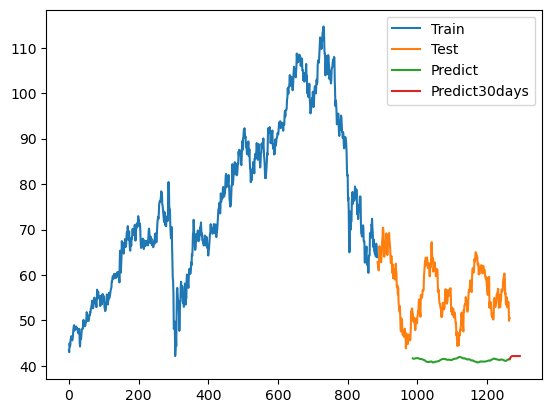

In [55]:
#Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=len(df1), step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=len(df1), step=1)
plt.plot(test_data_index,(y_pred))
#val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
#plt.plot(val_data_index,scaler.inverse_transform(val_data))
#val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
#plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [ ]:
#train-test (8-2)

In [ ]:
# Chia dữ liệu thành train và test (8-2)
train_size = int(0.8 * len(df1))
test_size = int(0.2 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:]

In [ ]:
# Hàm create_dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
# Reshape input to be [samples, time steps, features] which is required for GRU
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
def create_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=(100, 1)))
    model.add(GRU(50, return_sequences=True))
    model.add(GRU(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
# Hàm Bagging cho GRU
def bagging_gru(train_data, test_data, n_models=5):
    predictions = np.zeros(len(test_data))

    for _ in range(n_models):
        # Tạo mô hình GRU mới cho mỗi lần lặp
        model = create_gru_model(input_shape=train_data.shape[1])

        # Huấn luyện mô hình
        model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)

        # Dự đoán trên tập kiểm tra
        y_pred = model.predict(test_data)

        # Thêm dự đoán của mô hình vào tổng quan
        predictions += y_pred.flatten()

    # Trung bình dự đoán của các mô hình
    predictions /= n_models

    return predictions

In [ ]:
# Mô hình Bagging GRU
bagged_predictions = bagging_gru(X_train, X_test, n_models=5)

In [ ]:
# Đánh giá mô hình
rmse = np.sqrt(mean_squared_error(y_test, bagged_predictions))
mape = mean_absolute_percentage_error(y_test, bagged_predictions)
mae = mean_absolute_error(y_test, bagged_predictions)
mse = mean_squared_error(y_test, bagged_predictions)

# In kết quả
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")

In [ ]:
test_data.shape

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
#y_pred_val=model.predict(X_val)

In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
#y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[152:].reshape(1,-1)
x_input.shape
        
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
    
from numpy import array
        
lst_output=[]
n_steps=100
i=0
while(i<30):
            
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        n_steps = min(len(temp_input), 100)
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

In [ ]:
#Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=len(df1), step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=len(df1), step=1)
plt.plot(test_data_index,(y_pred))
#val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
#plt.plot(val_data_index,scaler.inverse_transform(val_data))
#val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
#plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [ ]:
#train-test (9-1)

In [ ]:
# Chia dữ liệu thành train và test (9-1)
train_size = int(0.9 * len(df1))
test_size = int(0.1 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:]

In [ ]:
# Hàm create_dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
# Reshape input to be [samples, time steps, features] which is required for GRU
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
def create_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=(100, 1)))
    model.add(GRU(50, return_sequences=True))
    model.add(GRU(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
# Hàm Bagging cho GRU
def bagging_gru(train_data, test_data, n_models=5):
    predictions = np.zeros(len(test_data))

    for _ in range(n_models):
        # Tạo mô hình GRU mới cho mỗi lần lặp
        model = create_gru_model(input_shape=train_data.shape[1])

        # Huấn luyện mô hình
        model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)

        # Dự đoán trên tập kiểm tra
        y_pred = model.predict(test_data)

        # Thêm dự đoán của mô hình vào tổng quan
        predictions += y_pred.flatten()

    # Trung bình dự đoán của các mô hình
    predictions /= n_models

    return predictions

In [ ]:
# Mô hình Bagging GRU
bagged_predictions = bagging_gru(X_train, X_test, n_models=5)

In [ ]:
# Đánh giá mô hình
rmse = np.sqrt(mean_squared_error(y_test, bagged_predictions))
mape = mean_absolute_percentage_error(y_test, bagged_predictions)
mae = mean_absolute_error(y_test, bagged_predictions)
mse = mean_squared_error(y_test, bagged_predictions)

# In kết quả
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")

In [ ]:
test_data.shape

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
#y_pred_val=model.predict(X_val)

In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
#y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[152:].reshape(1,-1)
x_input.shape
        
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
    
from numpy import array
        
lst_output=[]
n_steps=100
i=0
while(i<30):
            
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        n_steps = min(len(temp_input), 100)
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

In [ ]:
#Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=len(df1), step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=len(df1), step=1)
plt.plot(test_data_index,(y_pred))
#val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
#plt.plot(val_data_index,scaler.inverse_transform(val_data))
#val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
#plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()